In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import os
import glob
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch

from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from pif import PatchIndividualFilters3D

In [6]:
torch.__version__

'1.0.0'

In [7]:
# use multiple GPUs
gpu = 4
multi_gpus = None#[0, 1, 2]
b = 12
zero_one_normalize = False
dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [10]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [11]:
# shuffle the dataset
df = df.sample(frac=1, random_state=23) # NOTE: use all!
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
791,791,1109592,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1109592,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,3NY,1NN,0YY,1NN,1NN,3NY,MH.VH,VH.VH
1705,1705,1197086,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1197086,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,0YY,0YY,9else,2YN,3NY,0YY,1NN,9Na,9Na
167,167,1092621,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1092621,20252_2_0,20253_2_0,20249_2_0,Female,[],...,"4SitR,5DocR",2YN,1NN,1NN,1NN,1NN,3NY,1NN,9Na,9Na
331,331,1037619,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1037619,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,2YN,0YY,3NY,3NY,1NN,1NN,0YY,9Na,9Na
651,651,1161652,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1161652,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,3NY,3NY,1NN,0YY,1NN,3NY,2YN,9Na,9Na


In [12]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        path = path.replace("/analysis/ritter", "/ritter/share")
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        # normalize by max
        image /= np.max(image)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [13]:
augmentations = [SagittalFlip()]

In [14]:
intensity = IntensityRescale(masked=False)
if zero_one_normalize:
    input_trans = transforms.Compose(augmentations + [intensity, ToTensor()])
else:
    input_trans = transforms.Compose(augmentations + [ToTensor()])


In [15]:
ukb_data = UKBGDataset(df, transform=input_trans, mask=mask)

In [16]:
len(ukb_data)

1854

In [17]:
# split train/test
train_df = df.sample(frac=0.8, random_state=32)
test_df = df[~df["PTID"].isin(train_df["PTID"])]
print(len(test_df))

371


In [18]:
sample = ukb_data[3]
img = sample["image"]

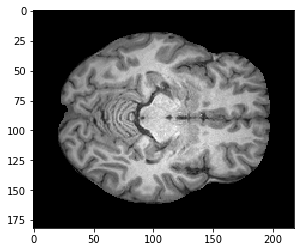

In [19]:
plt.imshow(img[0][:,:,60], cmap='gray')

In [20]:
sample["label"]

tensor([1.])

# Define the classifier

In [21]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([15,19,15],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=6,
                                            overlap=1,
                                            reassemble=False,
                                            debug=False)

        self.classifier_scratch = nn.Sequential(
            nn.Linear(7776, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)    
        h = F.elu(self.pif(x))
    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [22]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [23]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 1348665


# Training

In [24]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-5
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        
        # split train/validation
        train_df = data.sample(frac=0.8, random_state=32)
        val_df = data[~data["PTID"].isin(train_df["PTID"])]

        if zero_one_normalize:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        train_loader = DataLoader(
            ukb_data_train, batch_size=b, shuffle=True, num_workers=4
        )

        val_loader = DataLoader(
            ukb_data_val, batch_size=2, shuffle=True, num_workers=2
        )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=30,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric]))
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
            best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models

In [24]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [25]:
r = 3

In [26]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/full_set/experiment/"
callbacks = [EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

Starting trial 0
[0,    30] loss: 0.69066
[0,    60] loss: 0.69579
[0,    90] loss: 0.69524
Time elapsed: 0h:1m:56s
train accuracy_score: 52.36 %
train balanced_accuracy: 50.06 %
val accuracy_score: 45.45 %
val balanced_accuracy: 51.20 %
Val loss: 0.695391
[1,    30] loss: 0.69569
[1,    60] loss: 0.69533
[1,    90] loss: 0.69093
Time elapsed: 0h:4m:49s
train accuracy_score: 51.01 %
train balanced_accuracy: 50.03 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.684671
[2,    30] loss: 0.69182
[2,    60] loss: 0.69131
[2,    90] loss: 0.69284
Time elapsed: 0h:7m:45s
train accuracy_score: 52.53 %
train balanced_accuracy: 50.06 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.687476
[3,    30] loss: 0.68951
[3,    60] loss: 0.69532
[3,    90] loss: 0.69310
Time elapsed: 0h:10m:41s
train accuracy_score: 52.19 %
train balanced_accuracy: 50.16 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.685442
[4,    30] loss: 0.691

val accuracy_score: 92.59 %
val balanced_accuracy: 93.13 %
Val loss: 0.161786
[34,    30] loss: 0.10005
[34,    60] loss: 0.11215
[34,    90] loss: 0.15231
Time elapsed: 1h:40m:17s
train accuracy_score: 95.11 %
train balanced_accuracy: 95.11 %
val accuracy_score: 92.59 %
val balanced_accuracy: 92.49 %
Val loss: 0.161277
[35,    30] loss: 0.11695
[35,    60] loss: 0.11656
[35,    90] loss: 0.10212
Time elapsed: 1h:43m:11s
train accuracy_score: 95.19 %
train balanced_accuracy: 95.15 %
val accuracy_score: 92.59 %
val balanced_accuracy: 91.68 %
Val loss: 0.162193
[36,    30] loss: 0.11037
[36,    60] loss: 0.12095
[36,    90] loss: 0.12721
Time elapsed: 1h:46m:4s
train accuracy_score: 94.60 %
train balanced_accuracy: 94.58 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.48 %
Val loss: 0.136819
[37,    30] loss: 0.09436
[37,    60] loss: 0.16202
[37,    90] loss: 0.10292
Time elapsed: 1h:48m:59s
train accuracy_score: 95.11 %
train balanced_accuracy: 95.10 %
val accuracy_score: 94.28

Finished fold.


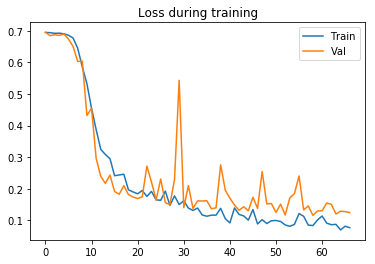

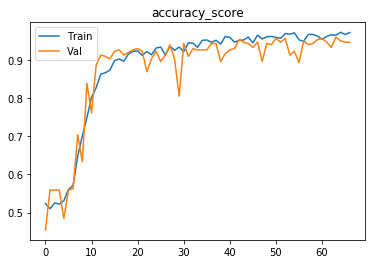

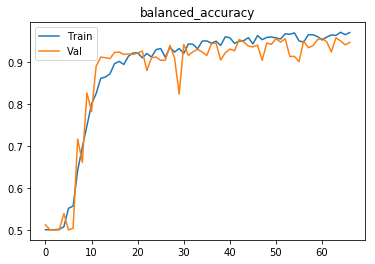

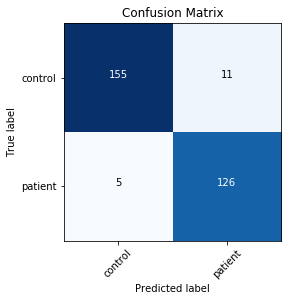

Starting trial 1
[0,    30] loss: 0.69898
[0,    60] loss: 0.69355
[0,    90] loss: 0.68925
Time elapsed: 0h:1m:57s
train accuracy_score: 51.18 %
train balanced_accuracy: 49.59 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686925
[1,    30] loss: 0.69500
[1,    60] loss: 0.69202
[1,    90] loss: 0.68908
Time elapsed: 0h:4m:52s
train accuracy_score: 53.20 %
train balanced_accuracy: 51.81 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686372
[2,    30] loss: 0.69291
[2,    60] loss: 0.69615
[2,    90] loss: 0.68320
Time elapsed: 0h:7m:46s
train accuracy_score: 53.37 %
train balanced_accuracy: 52.43 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.684637
[3,    30] loss: 0.69463
[3,    60] loss: 0.69058
[3,    90] loss: 0.68844
Time elapsed: 0h:10m:43s
train accuracy_score: 53.54 %
train balanced_accuracy: 51.77 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.691199
[4,    30] loss: 0.693

val accuracy_score: 93.27 %
val balanced_accuracy: 92.85 %
Val loss: 0.140971
[34,    30] loss: 0.13511
[34,    60] loss: 0.14749
[34,    90] loss: 0.11485
Time elapsed: 1h:41m:8s
train accuracy_score: 94.18 %
train balanced_accuracy: 94.16 %
val accuracy_score: 93.94 %
val balanced_accuracy: 93.93 %
Val loss: 0.134766
[35,    30] loss: 0.19818
[35,    60] loss: 0.18876
[35,    90] loss: 0.14932
Time elapsed: 1h:44m:2s
train accuracy_score: 92.66 %
train balanced_accuracy: 92.60 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.80 %
Val loss: 0.153320
[36,    30] loss: 0.11657
[36,    60] loss: 0.09335
[36,    90] loss: 0.10918
Time elapsed: 1h:46m:55s
train accuracy_score: 96.37 %
train balanced_accuracy: 96.35 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.99 %
Val loss: 0.202677
[37,    30] loss: 0.21947
[37,    60] loss: 0.17341
[37,    90] loss: 0.15158
Time elapsed: 1h:49m:47s
train accuracy_score: 92.92 %
train balanced_accuracy: 92.88 %
val accuracy_score: 89.23 

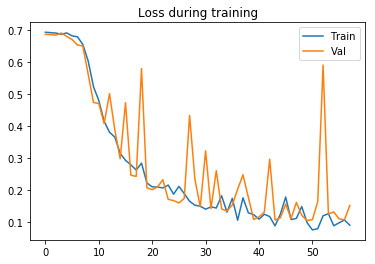

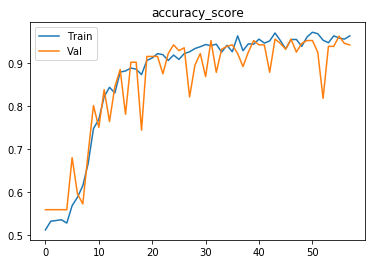

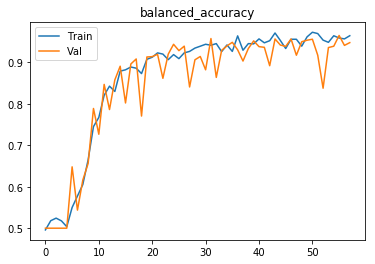

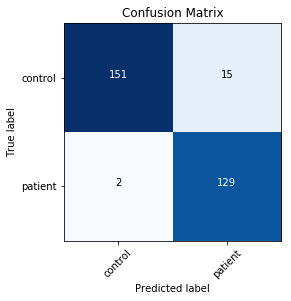

Starting trial 2
[0,    30] loss: 0.69068
[0,    60] loss: 0.69693
[0,    90] loss: 0.69763
Time elapsed: 0h:1m:54s
train accuracy_score: 52.36 %
train balanced_accuracy: 52.06 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.687424
[1,    30] loss: 0.69704
[1,    60] loss: 0.69504
[1,    90] loss: 0.69277
Time elapsed: 0h:4m:41s
train accuracy_score: 51.10 %
train balanced_accuracy: 49.39 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.688023
[2,    30] loss: 0.69237
[2,    60] loss: 0.69601
[2,    90] loss: 0.69461
Time elapsed: 0h:7m:34s
train accuracy_score: 50.51 %
train balanced_accuracy: 49.32 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.684133
[3,    30] loss: 0.69117
[3,    60] loss: 0.69140
[3,    90] loss: 0.69111
Time elapsed: 0h:10m:23s
train accuracy_score: 51.52 %
train balanced_accuracy: 49.79 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.688456
[4,    30] loss: 0.693

[34,    30] loss: 0.08602
[34,    60] loss: 0.15080
[34,    90] loss: 0.13077
Time elapsed: 1h:38m:40s
train accuracy_score: 94.44 %
train balanced_accuracy: 94.40 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.99 %
Val loss: 0.209887
[35,    30] loss: 0.10139
[35,    60] loss: 0.12883
[35,    90] loss: 0.08697
Time elapsed: 1h:41m:29s
train accuracy_score: 95.87 %
train balanced_accuracy: 95.85 %
val accuracy_score: 92.59 %
val balanced_accuracy: 93.05 %
Val loss: 0.161783
[36,    30] loss: 0.12398
[36,    60] loss: 0.15600
[36,    90] loss: 0.13024
Time elapsed: 1h:44m:20s
train accuracy_score: 94.01 %
train balanced_accuracy: 94.00 %
val accuracy_score: 89.90 %
val balanced_accuracy: 90.88 %
Val loss: 0.255290
[37,    30] loss: 0.12443
[37,    60] loss: 0.12019
[37,    90] loss: 0.11724
Time elapsed: 1h:47m:11s
train accuracy_score: 94.10 %
train balanced_accuracy: 94.10 %
val accuracy_score: 90.24 %
val balanced_accuracy: 91.10 %
Val loss: 0.198523
[38,    30] loss: 0.0967

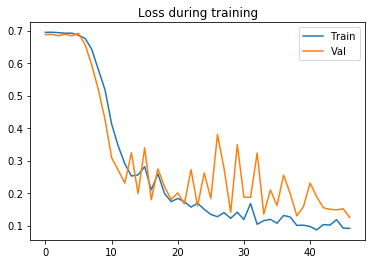

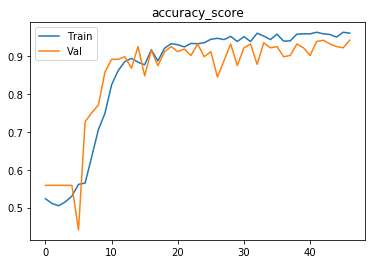

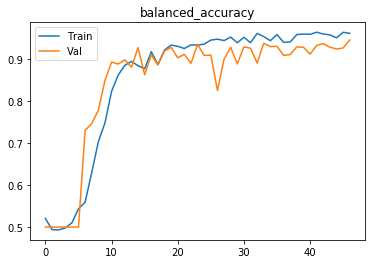

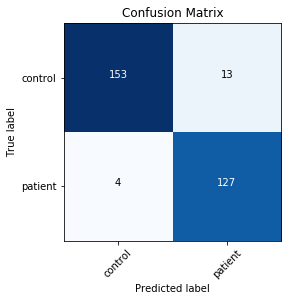

Starting trial 3
[0,    30] loss: 0.69472
[0,    60] loss: 0.69446
[0,    90] loss: 0.69735
Time elapsed: 0h:1m:52s
train accuracy_score: 49.41 %
train balanced_accuracy: 48.42 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.683940
[1,    30] loss: 0.68856
[1,    60] loss: 0.70714
[1,    90] loss: 0.69498
Time elapsed: 0h:4m:41s
train accuracy_score: 50.51 %
train balanced_accuracy: 48.69 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.694901
[2,    30] loss: 0.69248
[2,    60] loss: 0.69282
[2,    90] loss: 0.69433
Time elapsed: 0h:7m:34s
train accuracy_score: 52.11 %
train balanced_accuracy: 50.47 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.688235
[3,    30] loss: 0.69172
[3,    60] loss: 0.69021
[3,    90] loss: 0.69735
Time elapsed: 0h:10m:25s
train accuracy_score: 51.26 %
train balanced_accuracy: 49.73 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.682357
[4,    30] loss: 0.693

val accuracy_score: 91.92 %
val balanced_accuracy: 92.77 %
Val loss: 0.203078
[34,    30] loss: 0.20778
[34,    60] loss: 0.12393
[34,    90] loss: 0.11171
Time elapsed: 1h:38m:58s
train accuracy_score: 94.69 %
train balanced_accuracy: 94.67 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.32 %
Val loss: 0.161895
[35,    30] loss: 0.15009
[35,    60] loss: 0.11723
[35,    90] loss: 0.16015
Time elapsed: 1h:41m:50s
train accuracy_score: 94.35 %
train balanced_accuracy: 94.36 %
val accuracy_score: 94.61 %
val balanced_accuracy: 94.94 %
Val loss: 0.126205
[36,    30] loss: 0.10026
[36,    60] loss: 0.16553
[36,    90] loss: 0.11617
Time elapsed: 1h:44m:43s
train accuracy_score: 95.11 %
train balanced_accuracy: 95.16 %
val accuracy_score: 89.56 %
val balanced_accuracy: 88.17 %
Val loss: 0.239073
[37,    30] loss: 0.17634
[37,    60] loss: 0.18676
[37,    90] loss: 0.13779
Time elapsed: 1h:47m:34s
train accuracy_score: 93.17 %
train balanced_accuracy: 93.14 %
val accuracy_score: 94.6

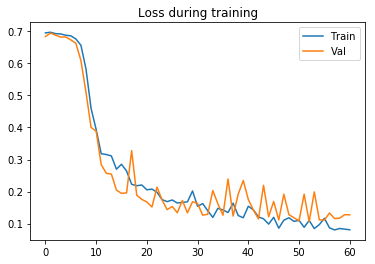

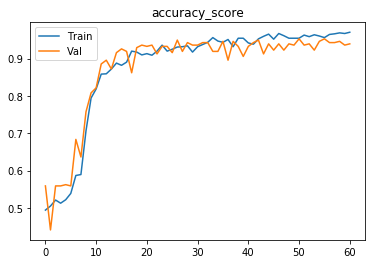

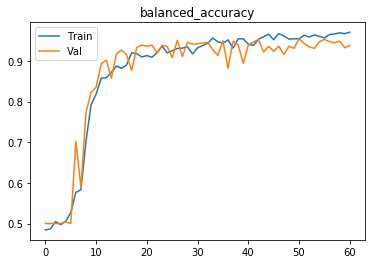

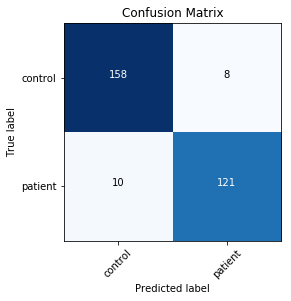

Starting trial 4
[0,    30] loss: 0.70199
[0,    60] loss: 0.69182
[0,    90] loss: 0.69238
Time elapsed: 0h:1m:51s
train accuracy_score: 50.34 %
train balanced_accuracy: 49.57 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.685877
[1,    30] loss: 0.69876
[1,    60] loss: 0.70092
[1,    90] loss: 0.69274
Time elapsed: 0h:4m:39s
train accuracy_score: 49.66 %
train balanced_accuracy: 48.72 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.688033
[2,    30] loss: 0.69204
[2,    60] loss: 0.69916
[2,    90] loss: 0.69609
Time elapsed: 0h:7m:26s
train accuracy_score: 52.53 %
train balanced_accuracy: 51.34 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.710111
[3,    30] loss: 0.69705
[3,    60] loss: 0.69395
[3,    90] loss: 0.69222
Time elapsed: 0h:10m:14s
train accuracy_score: 51.94 %
train balanced_accuracy: 50.85 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686943
[4,    30] loss: 0.688

[34,    30] loss: 0.14907
[34,    60] loss: 0.13681
[34,    90] loss: 0.07924
Time elapsed: 1h:38m:0s
train accuracy_score: 95.19 %
train balanced_accuracy: 95.18 %
val accuracy_score: 94.28 %
val balanced_accuracy: 93.59 %
Val loss: 0.165784
[35,    30] loss: 0.12040
[35,    60] loss: 0.11309
[35,    90] loss: 0.18717
Time elapsed: 1h:40m:53s
train accuracy_score: 93.93 %
train balanced_accuracy: 93.87 %
val accuracy_score: 93.94 %
val balanced_accuracy: 93.37 %
Val loss: 0.141492
[36,    30] loss: 0.11802
[36,    60] loss: 0.16506
[36,    90] loss: 0.09908
Time elapsed: 1h:43m:43s
train accuracy_score: 94.60 %
train balanced_accuracy: 94.60 %
val accuracy_score: 93.94 %
val balanced_accuracy: 94.10 %
Val loss: 0.148406
[37,    30] loss: 0.10631
[37,    60] loss: 0.11023
[37,    90] loss: 0.12215
Time elapsed: 1h:46m:34s
train accuracy_score: 95.19 %
train balanced_accuracy: 95.17 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.57 %
Val loss: 0.172667
[38,    30] loss: 0.14108

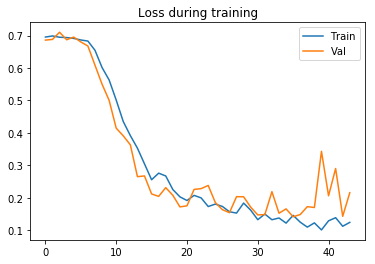

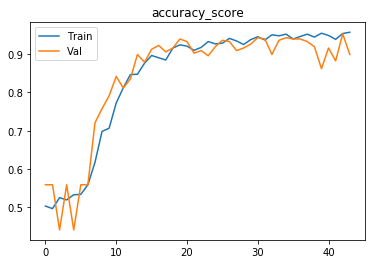

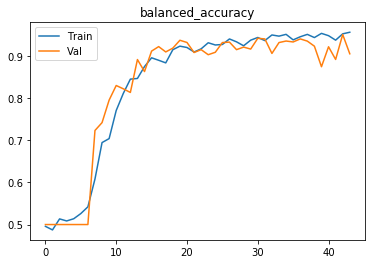

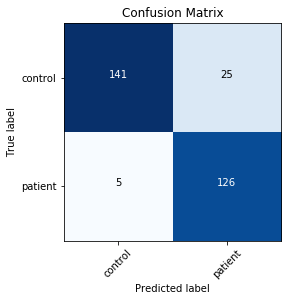

Starting trial 5
[0,    30] loss: 0.69391
[0,    60] loss: 0.69148
[0,    90] loss: 0.69440
Time elapsed: 0h:1m:52s
train accuracy_score: 53.29 %
train balanced_accuracy: 51.05 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.712202
[1,    30] loss: 0.69453
[1,    60] loss: 0.68865
[1,    90] loss: 0.69028
Time elapsed: 0h:4m:40s
train accuracy_score: 51.94 %
train balanced_accuracy: 50.05 %
val accuracy_score: 60.27 %
val balanced_accuracy: 63.41 %
Val loss: 0.691670
[2,    30] loss: 0.68803
[2,    60] loss: 0.69457
[2,    90] loss: 0.69301
Time elapsed: 0h:7m:32s
train accuracy_score: 52.11 %
train balanced_accuracy: 50.18 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.681050
[3,    30] loss: 0.69054
[3,    60] loss: 0.68947
[3,    90] loss: 0.68383
Time elapsed: 0h:10m:20s
train accuracy_score: 54.64 %
train balanced_accuracy: 53.12 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.676598
[4,    30] loss: 0.680

[34,    30] loss: 0.17186
[34,    60] loss: 0.10573
[34,    90] loss: 0.09722
Time elapsed: 1h:37m:40s
train accuracy_score: 95.03 %
train balanced_accuracy: 95.04 %
val accuracy_score: 92.93 %
val balanced_accuracy: 93.51 %
Val loss: 0.151737
[35,    30] loss: 0.09604
[35,    60] loss: 0.08443
[35,    90] loss: 0.10323
Time elapsed: 1h:40m:31s
train accuracy_score: 96.04 %
train balanced_accuracy: 96.01 %
val accuracy_score: 92.93 %
val balanced_accuracy: 93.43 %
Val loss: 0.146553
[36,    30] loss: 0.10311
[36,    60] loss: 0.08653
[36,    90] loss: 0.13914
Time elapsed: 1h:43m:19s
train accuracy_score: 95.36 %
train balanced_accuracy: 95.33 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.01 %
Val loss: 0.123284
[37,    30] loss: 0.13864
[37,    60] loss: 0.09622
[37,    90] loss: 0.10637
Time elapsed: 1h:46m:11s
train accuracy_score: 94.77 %
train balanced_accuracy: 94.76 %
val accuracy_score: 92.59 %
val balanced_accuracy: 91.60 %
Val loss: 0.190709
[38,    30] loss: 0.1009

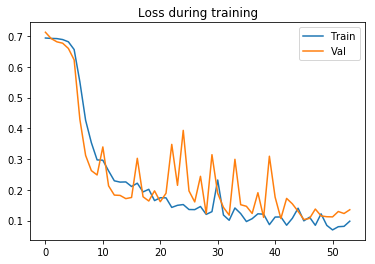

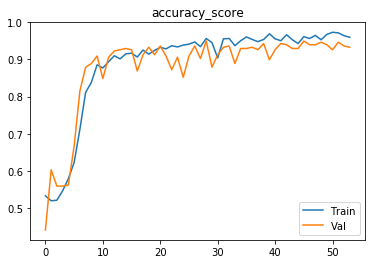

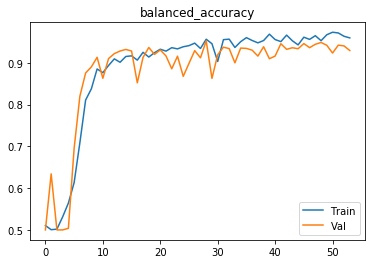

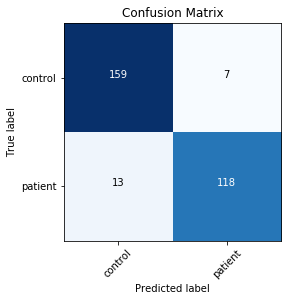

Starting trial 6
[0,    30] loss: 0.70280
[0,    60] loss: 0.69978
[0,    90] loss: 0.68954
Time elapsed: 0h:1m:51s
train accuracy_score: 51.01 %
train balanced_accuracy: 50.15 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.685417
[1,    30] loss: 0.69669
[1,    60] loss: 0.69279
[1,    90] loss: 0.69622
Time elapsed: 0h:4m:41s
train accuracy_score: 49.24 %
train balanced_accuracy: 47.67 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.700235
[2,    30] loss: 0.69135
[2,    60] loss: 0.69019
[2,    90] loss: 0.69841
Time elapsed: 0h:7m:27s
train accuracy_score: 50.84 %
train balanced_accuracy: 49.58 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.697162
[3,    30] loss: 0.69091
[3,    60] loss: 0.69586
[3,    90] loss: 0.69377
Time elapsed: 0h:10m:17s
train accuracy_score: 51.77 %
train balanced_accuracy: 50.91 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.684475
[4,    30] loss: 0.693

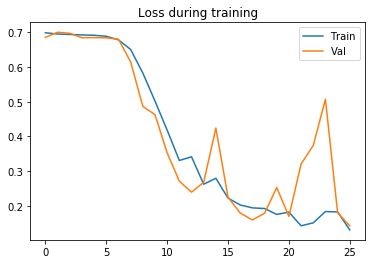

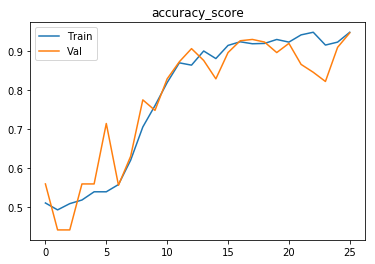

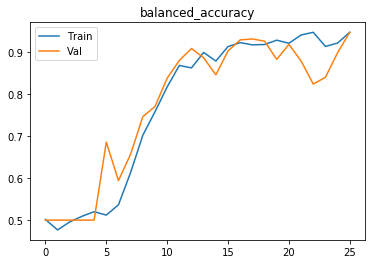

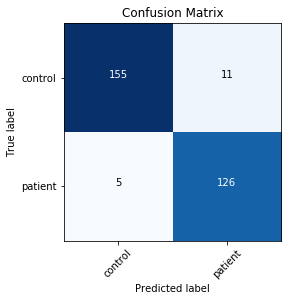

Starting trial 7
[0,    30] loss: 0.69815
[0,    60] loss: 0.69325
[0,    90] loss: 0.69410
Time elapsed: 0h:1m:53s
train accuracy_score: 51.01 %
train balanced_accuracy: 50.24 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.696555
[1,    30] loss: 0.69634
[1,    60] loss: 0.69667
[1,    90] loss: 0.69438
Time elapsed: 0h:4m:43s
train accuracy_score: 50.34 %
train balanced_accuracy: 49.25 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.693942
[2,    30] loss: 0.69512
[2,    60] loss: 0.68694
[2,    90] loss: 0.69184
Time elapsed: 0h:7m:34s
train accuracy_score: 52.95 %
train balanced_accuracy: 51.25 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.684943
[3,    30] loss: 0.69325
[3,    60] loss: 0.68153
[3,    90] loss: 0.69241
Time elapsed: 0h:10m:22s
train accuracy_score: 54.30 %
train balanced_accuracy: 52.98 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.708165
[4,    30] loss: 0.691

val accuracy_score: 93.27 %
val balanced_accuracy: 93.49 %
Val loss: 0.166837
[34,    30] loss: 0.10353
[34,    60] loss: 0.14420
[34,    90] loss: 0.10260
Time elapsed: 1h:38m:23s
train accuracy_score: 95.53 %
train balanced_accuracy: 95.56 %
val accuracy_score: 91.92 %
val balanced_accuracy: 91.40 %
Val loss: 0.158844
[35,    30] loss: 0.14420
[35,    60] loss: 0.11036
[35,    90] loss: 0.12264
Time elapsed: 1h:41m:16s
train accuracy_score: 94.77 %
train balanced_accuracy: 94.72 %
val accuracy_score: 91.58 %
val balanced_accuracy: 92.39 %
Val loss: 0.239123
[36,    30] loss: 0.13480
[36,    60] loss: 0.10666
[36,    90] loss: 0.08043
Time elapsed: 1h:44m:8s
train accuracy_score: 96.12 %
train balanced_accuracy: 96.09 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.81 %
Val loss: 0.166355
[37,    30] loss: 0.14372
[37,    60] loss: 0.18101
[37,    90] loss: 0.17828
Time elapsed: 1h:46m:55s
train accuracy_score: 94.01 %
train balanced_accuracy: 94.02 %
val accuracy_score: 93.94

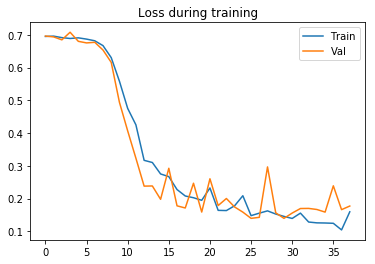

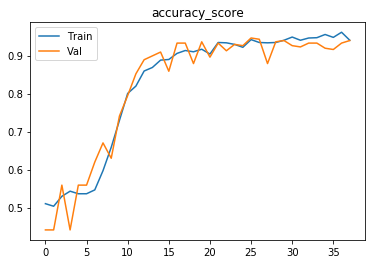

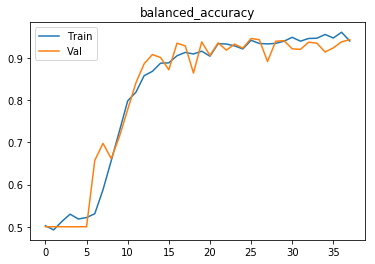

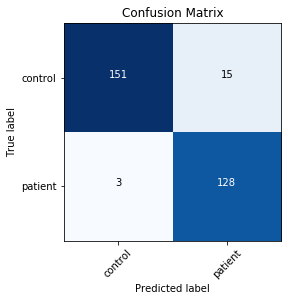

Starting trial 8
[0,    30] loss: 0.69409
[0,    60] loss: 0.69335
[0,    90] loss: 0.69520
Time elapsed: 0h:1m:53s
train accuracy_score: 52.61 %
train balanced_accuracy: 51.34 %
val accuracy_score: 44.11 %
val balanced_accuracy: 50.00 %
Val loss: 0.693380
[1,    30] loss: 0.69472
[1,    60] loss: 0.68753
[1,    90] loss: 0.69115
Time elapsed: 0h:4m:42s
train accuracy_score: 54.13 %
train balanced_accuracy: 52.84 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.682958
[2,    30] loss: 0.69270
[2,    60] loss: 0.69451
[2,    90] loss: 0.68259
Time elapsed: 0h:7m:32s
train accuracy_score: 53.96 %
train balanced_accuracy: 52.87 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.686506
[3,    30] loss: 0.68793
[3,    60] loss: 0.69609
[3,    90] loss: 0.68955
Time elapsed: 0h:10m:21s
train accuracy_score: 52.78 %
train balanced_accuracy: 51.46 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.681804
[4,    30] loss: 0.692

val accuracy_score: 92.93 %
val balanced_accuracy: 93.43 %
Val loss: 0.141913
[34,    30] loss: 0.11789
[34,    60] loss: 0.10429
[34,    90] loss: 0.12245
Time elapsed: 1h:38m:6s
train accuracy_score: 95.36 %
train balanced_accuracy: 95.34 %
val accuracy_score: 95.29 %
val balanced_accuracy: 95.22 %
Val loss: 0.100026
[35,    30] loss: 0.09278
[35,    60] loss: 0.13714
[35,    90] loss: 0.14343
Time elapsed: 1h:40m:55s
train accuracy_score: 94.52 %
train balanced_accuracy: 94.51 %
val accuracy_score: 94.95 %
val balanced_accuracy: 94.76 %
Val loss: 0.136869
[36,    30] loss: 0.11757
[36,    60] loss: 0.09951
[36,    90] loss: 0.09310
Time elapsed: 1h:43m:43s
train accuracy_score: 95.28 %
train balanced_accuracy: 95.26 %
val accuracy_score: 95.29 %
val balanced_accuracy: 95.46 %
Val loss: 0.109929
[37,    30] loss: 0.13120
[37,    60] loss: 0.13749
[37,    90] loss: 0.12333
Time elapsed: 1h:46m:31s
train accuracy_score: 94.77 %
train balanced_accuracy: 94.73 %
val accuracy_score: 92.93

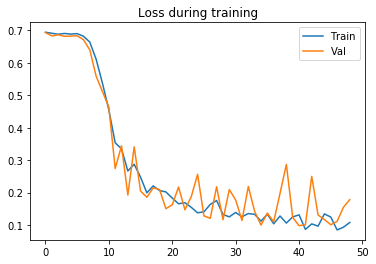

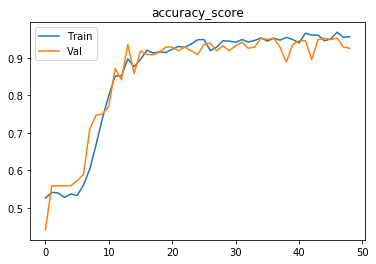

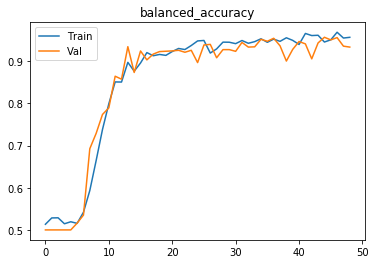

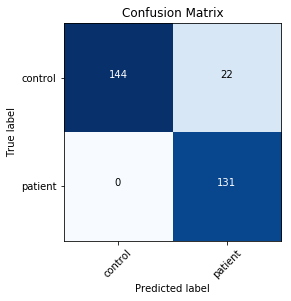

Starting trial 9
[0,    30] loss: 0.69450
[0,    60] loss: 0.69466
[0,    90] loss: 0.69063
Time elapsed: 0h:1m:55s
train accuracy_score: 52.28 %
train balanced_accuracy: 49.93 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.687538
[1,    30] loss: 0.69233
[1,    60] loss: 0.68843
[1,    90] loss: 0.69628
Time elapsed: 0h:4m:47s
train accuracy_score: 52.78 %
train balanced_accuracy: 50.79 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.687702
[2,    30] loss: 0.69203
[2,    60] loss: 0.68853
[2,    90] loss: 0.69062
Time elapsed: 0h:7m:36s
train accuracy_score: 54.81 %
train balanced_accuracy: 52.84 %
val accuracy_score: 55.89 %
val balanced_accuracy: 50.00 %
Val loss: 0.681381
[3,    30] loss: 0.69426
[3,    60] loss: 0.68275
[3,    90] loss: 0.68303
Time elapsed: 0h:10m:28s
train accuracy_score: 55.99 %
train balanced_accuracy: 54.48 %
val accuracy_score: 68.69 %
val balanced_accuracy: 70.62 %
Val loss: 0.681639
[4,    30] loss: 0.681

val accuracy_score: 93.27 %
val balanced_accuracy: 92.53 %
Val loss: 0.156763
[34,    30] loss: 0.11961
[34,    60] loss: 0.23383
[34,    90] loss: 0.09924
Time elapsed: 1h:38m:33s
train accuracy_score: 93.93 %
train balanced_accuracy: 93.92 %
val accuracy_score: 94.28 %
val balanced_accuracy: 94.07 %
Val loss: 0.135712
[35,    30] loss: 0.09030
[35,    60] loss: 0.13963
[35,    90] loss: 0.13391
Time elapsed: 1h:41m:23s
train accuracy_score: 95.36 %
train balanced_accuracy: 95.35 %
val accuracy_score: 94.28 %
val balanced_accuracy: 93.75 %
Val loss: 0.122753
[36,    30] loss: 0.11643
[36,    60] loss: 0.07105
[36,    90] loss: 0.13453
Time elapsed: 1h:44m:16s
train accuracy_score: 95.53 %
train balanced_accuracy: 95.51 %
val accuracy_score: 95.29 %
val balanced_accuracy: 95.22 %
Val loss: 0.109027
[37,    30] loss: 0.08055
[37,    60] loss: 0.08149
[37,    90] loss: 0.13256
Time elapsed: 1h:47m:7s
train accuracy_score: 95.95 %
train balanced_accuracy: 95.95 %
val accuracy_score: 93.27

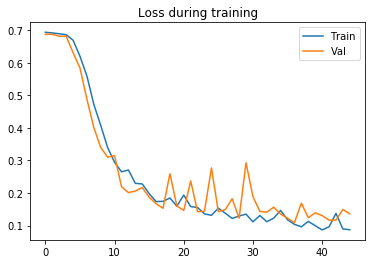

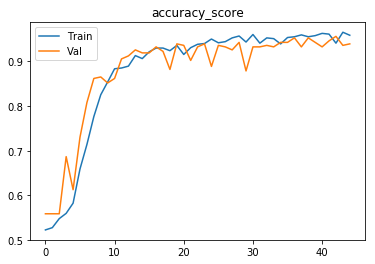

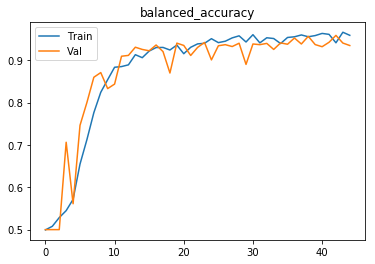

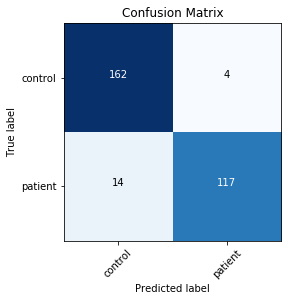

################################
################################
All accuracies: [0.9477835004138692, 0.9471856893221742, 0.9455761979214569, 0.9377356755265337, 0.905614825715074, 0.9292973420399154, 0.9477835004138692, 0.9433688954290445, 0.9337349397590362, 0.9345166927250991]
Best accuracies mean: 0.9536880345810722 All :[0.9590269474845949, 0.9644532327784419, 0.9455761979214569, 0.9546123424997702, 0.9513933596983352, 0.9524050400073576, 0.9477835004138692, 0.946174009013152, 0.9570265796008462, 0.9584291363928998]
0.9372597259266072
0.012294243408801303


In [28]:
fold_metric, models = run(net=net, data=train_df,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [29]:
5/0

ZeroDivisionError: division by zero

# Start inference

### Using best model checkpoint for inference

In [27]:
if zero_one_normalize:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
else:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
            
test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [28]:
model_dirs = [os.path.join(output_dir,"repeat_{}_cv_fold_{}_BEST_ITERATION.h5".format(r, i)) for i in range(10)]

In [29]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Fold 0
Bal. accuracy 92.393 %
ROC AUC Score 98.513 %
Sensitivity 90.000 %
Specificity 94.787 %
Fold 1
Bal. accuracy 95.982 %
ROC AUC Score 99.251 %
Sensitivity 98.125 %
Specificity 93.839 %
Fold 2
Bal. accuracy 94.419 %
ROC AUC Score 98.697 %
Sensitivity 95.000 %
Specificity 93.839 %
Fold 3
Bal. accuracy 93.794 %
ROC AUC Score 98.392 %
Sensitivity 93.750 %
Specificity 93.839 %
Fold 4
Bal. accuracy 93.406 %
ROC AUC Score 98.448 %
Sensitivity 92.500 %
Specificity 94.313 %
Fold 5
Bal. accuracy 93.557 %
ROC AUC Score 98.095 %
Sensitivity 93.750 %
Specificity 93.365 %
Fold 6
Bal. accuracy 93.794 %
ROC AUC Score 98.395 %
Sensitivity 93.750 %
Specificity 93.839 %
Fold 7
Bal. accuracy 92.307 %
ROC AUC Score 97.971 %
Sensitivity 91.250 %
Specificity 93.365 %
Fold 8
Bal. accuracy 93.149 %
ROC AUC Score 98.866 %
Sensitivity 96.250 %
Specificity 90.047 %
Fold 9
Bal. accuracy 94.656 %
ROC AUC Score 98.791 %
Sensitivity 95.000 %
Specificity 94.313 %
######## Final results ########
    Bal Acc   ROC 

In [32]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model_dir in enumerate(model_dirs):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    net = SixtyFourNet()
    net.load_state_dict(torch.load(model_dir))
    net = net.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))

Fold 0
0.9239336492890995
Fold 1
0.9598193127962085
Fold 2
0.9441943127962085
Fold 3
0.9379443127962086
Fold 4
0.9340639810426541
Fold 5
0.935574644549763
Fold 6
0.9379443127962086
Fold 7
0.9230746445497631
Fold 8
0.9314869668246446
Fold 9
0.946563981042654
######## Final results ########
          0
0  0.923934
1  0.959819
2  0.944194
3  0.937944
4  0.934064
5  0.935575
6  0.937944
7  0.923075
8  0.931487
9  0.946564
Balanced accuracy mean 93.75 %
